<a href="https://colab.research.google.com/github/CoWoGeo/PUS2022_CWolk/blob/main/MidtermLathamWolk/LIBusinessLicenses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Philadelphia L&I Business Licenses

Data and overview here: https://www.opendataphilly.org/dataset/licenses-and-inspections-business-licenses

City's data visualization (with helpful search tool) here: https://data.phila.gov/visualizations/li-business-licenses

This will be the foundational data set for our project. Our core data from this is every site that has ever had a junkyard license, plus every license attached to that parcel. The logic for this is that we know that there are far more operating junkyards than sites with active junkyard licenses (based on news coverage and the Scrapyard Task Force's own report) and there does not seem to be much enforcement of license renewals, so junkyards with lapsed licenses are a logical place to look. 

We also hope to look for sites that have never had junkyard licenses but whose business names and licenses make them likely candidates, such as having auto repair or part licenses and "scrap" or "junk" in the name. This might need to be a later project, though, as the dividing line between an auto repair or used tire place and a junkyard is blurry and we might need to figure out additional criteria such as parcel size, violations, types of complaints, etc.

## Order of operations:


1.   Import business licenses dataset
2.   Remove irrelevant columns, clean up rows with significant NaNs
3. Find most common irrelevant business license type (in this case, Rental) and remove it from the dataframe to make it smaller and more manageable
4. Extract all sites that have ever had junkyard licenses
5. Extract all sites that have active junkyard licenses for numeric context
6. Find a column to use to find all licenses for junkyard sites. This ended up being the geometry column because no other column was reliable or complete enough.
7. Create a geodataframe of sites with junkyard licenses and all other licenses for those locations.
8. Import Philadelphia Department of Records Parcel shapefile. 
9. Use Philadelphia Department of Records Parcels to merge correct parcel data and street addresses with license locations, replace point geometry of business licenses with parcel shape geometry.
10. Probably download this dataset and upload it to Google Drive so that we can use it in other notebooks without having to rerun all the very slow imports and loops.
11. Do some data analysis on the types of licenses and data quality.



# Importing and Installing Libraries

In [ ]:
!apt install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg

In [ ]:
! pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cartoframes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 7.7 MB/s 
     |████████████████████████████████| 235 kB 38.0 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 16.6 MB 147 kB/s 
     |████████████████████████████████| 7.8 MB 38.0 MB/s 
  Created wheel for carto: filename=carto-1.11.3-py3-none-any.whl size=35088 sha256=2898fa1089254968129d18177bed2f08fcdc6476c13ce6e1be271e0d037d40aa
  Stored in directory: /root/.cache/pip/wheels/6b/a3/41/90fa4334cd280f91d17226f36db7a34b12902f7e5b281afb84
  Created wheel for pyrestcli: filename=pyrestcli-0.6.11-py3-none-any.whl size=8496 sha256=2eabcc3e5e40685cee14196844a696762edf859af00781be1c050b5baaab5178
  Stored in directory: /root/.cache/pip/wheels/92/fc/98/2e46573b8e1bbe953345578314c765d3ecdc9532450bb90d79
Successfully built carto pyrestcli


In [ ]:
!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

In [ ]:
import cartoframes as cf

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from shapely.geometry import Point

In [ ]:
import numpy as np

# Importing and Exploring Business Licenses Data

In [ ]:
licenses = gpd.GeoDataFrame.from_file("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+business_licenses&filename=business_licenses&format=shp&skipfields=cartodb_id")

In [ ]:
#I really want to edit the link to import just the columns I want and cut the
#rental licenses before importing them to save time and storage. But how?
#licenses = gpd.GeoDataFrame.from_file("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+business_licenses&filename=business_licenses&format=shp&skipfields=cartodb_id&WHERE+licensetyp==Rental=False)

In [ ]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 395151 entries, 0 to 395150
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    395151 non-null  int64   
 1   addressobj  375373 non-null  float64 
 2   address     377895 non-null  object  
 3   unit_type   115924 non-null  object  
 4   unit_num    115389 non-null  object  
 5   zip         377869 non-null  object  
 6   censustrac  377372 non-null  object  
 7   parcel_id_  376062 non-null  object  
 8   opa_accoun  367738 non-null  object  
 9   opa_owner   367483 non-null  object  
 10  licensenum  395151 non-null  object  
 11  revenuecod  395151 non-null  object  
 12  licensetyp  395151 non-null  object  
 13  rentalcate  229799 non-null  object  
 14  initialiss  395151 non-null  object  
 15  mostrecent  395151 non-null  object  
 16  expiration  386065 non-null  object  
 17  inactiveda  227282 non-null  object  
 18  licensesta  3951

## Cleaning Business License Data

Here is the metadata page: https://metadata.phila.gov/#home/datasetdetails/5543865a20583086178c4ed2/representationdetails/5e985a5e344ed50018936bb8/

A useful explanation for OPA Account Number: "Office of Property Assessment Account Number' Every land parcel within the City of Philadelphia is assigned a unique account number from OPA. This number stays with the property for as long as the deed is held by the same owner. Once a property transfers ownership, it is assigned a new OPA account number and the old one is retired.

"This field can be used as a join key for various city datasets. It is also sometimes known as the 'BRT' number or within some datasets coming directly from OPA is also called the 'PARCEL_NUMBER'. (Other departments may use different internal 'Parcel Numbers', so please verify before using)"

This is both incredibly confusing/messy and useful: multiple OPA Account Numbers being tagged to the same address will show us that the property changed hands. (This is often very slow to show up in records, in my experience, though!)

POSSE JOBI: "Objectid and join field for related records" But there are other fields they say are join fields and other objectids!

In [ ]:
# drop multiple columns by index, dropping all this owner contact info
cols  = licenses.columns
licenses.drop(columns =cols[27:37], inplace=True)

In [ ]:
#dropping columns related to housing rental licenses
licenses = licenses.drop(columns=["numberofun", "owneroccup"], axis=1)

In [ ]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 395151 entries, 0 to 395150
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    395151 non-null  int64   
 1   addressobj  375373 non-null  float64 
 2   address     377895 non-null  object  
 3   unit_type   115924 non-null  object  
 4   unit_num    115389 non-null  object  
 5   zip         377869 non-null  object  
 6   censustrac  377372 non-null  object  
 7   parcel_id_  376062 non-null  object  
 8   opa_accoun  367738 non-null  object  
 9   opa_owner   367483 non-null  object  
 10  licensenum  395151 non-null  object  
 11  revenuecod  395151 non-null  object  
 12  licensetyp  395151 non-null  object  
 13  rentalcate  229799 non-null  object  
 14  initialiss  395151 non-null  object  
 15  mostrecent  395151 non-null  object  
 16  expiration  386065 non-null  object  
 17  inactiveda  227282 non-null  object  
 18  licensesta  3951

In [ ]:
licensetype = licenses["licensetyp"]
licensetype.describe()

count     395151
unique        53
top       Rental
freq      252007
Name: licensetyp, dtype: object

There are 53 types of licenses in the data set, with Rental as the most frequent. Rental isn't relevant to us!

In [ ]:
# Removing the many Rental records from the dataframe
licenses = licenses[licenses["licensetyp"].str.contains("Rental") == False]

In [ ]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 143144 entries, 0 to 395137
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    143144 non-null  int64   
 1   addressobj  123720 non-null  float64 
 2   address     126437 non-null  object  
 3   unit_type   36614 non-null   object  
 4   unit_num    36406 non-null   object  
 5   zip         126436 non-null  object  
 6   censustrac  126249 non-null  object  
 7   parcel_id_  125014 non-null  object  
 8   opa_accoun  122226 non-null  object  
 9   opa_owner   122042 non-null  object  
 10  licensenum  143144 non-null  object  
 11  revenuecod  143144 non-null  object  
 12  licensetyp  143144 non-null  object  
 13  rentalcate  0 non-null       object  
 14  initialiss  143144 non-null  object  
 15  mostrecent  143144 non-null  object  
 16  expiration  134058 non-null  object  
 17  inactiveda  79216 non-null   object  
 18  licensesta  1431

In [ ]:
licensetype.describe()

count     395151
unique        53
top       Rental
freq      252007
Name: licensetyp, dtype: object

The next most frequent is "Vacant Residential Property / Lot." We need this for later because fly-by-night scrapyards are likely on vacant lots, but we don't need it now. Now we know that there are 34,955 vacant lots in Philadelphia!

Before, I had left a lot of columns in at this stage, but now that I've explored the data a lot and at Fed's urging, I'll drop more. I am keeping other non-essential columns for the data exploration aspect and to show the steps I took to choose a process.

In [ ]:
licenses = licenses.drop(columns=["unit_type", "unit_num", "rentalcate",
                                  "council_di", "posse_jobi"], axis=1)

In [ ]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 143144 entries, 0 to 395137
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    143144 non-null  int64   
 1   addressobj  123720 non-null  float64 
 2   address     126437 non-null  object  
 3   zip         126436 non-null  object  
 4   censustrac  126249 non-null  object  
 5   parcel_id_  125014 non-null  object  
 6   opa_accoun  122226 non-null  object  
 7   opa_owner   122042 non-null  object  
 8   licensenum  143144 non-null  object  
 9   revenuecod  143144 non-null  object  
 10  licensetyp  143144 non-null  object  
 11  initialiss  143144 non-null  object  
 12  mostrecent  143144 non-null  object  
 13  expiration  134058 non-null  object  
 14  inactiveda  79216 non-null   object  
 15  licensesta  143144 non-null  object  
 16  legalfirst  51190 non-null   object  
 17  legallastn  51188 non-null   object  
 18  legalname   1428

# Junkyards and Associated Licenses!

## Creating a dataframe of just junkyard licenses aka LicensedJunk

In a future, more detailed version of this project, we'd search by business name and then search them online to find businesses that are clearly junkyards/scrapyards but have never had a license for it, and/or try to differentiate between licensed junkyards that are truly more of a small auto repair shop than primarily about junk. Philly also has a huge overlapping problem of businesses getting auto repair shop licenses and zoning exemptions to operate in residential areas and then operating as more of a junkyard. (There are several walking distance from Coryn's house!)

In [ ]:
licensedjunk = licenses[licenses["licensetyp"].str.contains("Auto Wrecking / Junk Yard")]

In [ ]:
licensedjunk.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 274 entries, 85134 to 394130
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    274 non-null    int64   
 1   addressobj  270 non-null    float64 
 2   address     270 non-null    object  
 3   zip         270 non-null    object  
 4   censustrac  270 non-null    object  
 5   parcel_id_  239 non-null    object  
 6   opa_accoun  230 non-null    object  
 7   opa_owner   230 non-null    object  
 8   licensenum  274 non-null    object  
 9   revenuecod  274 non-null    object  
 10  licensetyp  274 non-null    object  
 11  initialiss  274 non-null    object  
 12  mostrecent  274 non-null    object  
 13  expiration  274 non-null    object  
 14  inactiveda  186 non-null    object  
 15  licensesta  274 non-null    object  
 16  legalfirst  99 non-null     object  
 17  legallastn  99 non-null     object  
 18  legalname   274 non-null    object 

I could have just done that to start with, but all the datacleaning above will make the licenses dataframe smaller and easier to work with in future steps.

In [ ]:
# looking at rows without geometry
nogeometry = licensedjunk[licensedjunk["geometry"].isna()]
nogeometry

,objectid,addressobj,address,zip,censustrac,parcel_id_,opa_accoun,opa_owner,licensenum,revenuecod,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
85758,84641,NaN,None,None,None,None,None,None,287719,3374,...,Inactive,None,None,LAM AUTO SALES CO,Company,LAM AUTO SALES CO,"1901 WESTMORELAND ST PHILADELPHIA, PA 19140 USA",NaN,NaN,None
101587,104242,NaN,None,None,None,None,None,None,323045,3374,...,Inactive,None,None,KNOCK OUT AUTO PARTS LLC,Company,KNOCK OUT AUTO PARTS LLC,"3201 E TIOGA ST PHILADELPHIA, PA 19134 USA",NaN,NaN,None
104830,106574,NaN,None,None,None,None,None,None,327115,3374,...,Inactive,None,None,PORT RICHMOND AUTO INC,Company,PORT RICHMOND AUTO INC,"3950 N DELAWARE AVE PHILADELPHIA, PA USA",NaN,NaN,None
109310,97271,NaN,None,None,None,None,None,None,311520,3374,...,Inactive,KEVIN,CREEDON,CREEDON KEVIN,Individual,KEVINS USED AUTO PARTS,"423 W LUZERNE ST PHILADELPHIA, PA 19140 USA",NaN,NaN,None


An illustration of how messy this data is! I looked up Kevin's Used Auto Parts, one of the entries missing most of the data and with an inactive Junk Yard license, in the city API and found a second entry with the same business name and an inactive license for towing. However, that business had the address of 990 Spring Garden St, which is a real estate company. I searched 423 W. Luzerne St and got a few auto parts companies with no obvious name. However, satellite images show some junkyards at the pin for 423 W. Luzerne St. (Incidentally, next to a police station.) Then I searched the owner, Kevin Creedon, and found another inactive junkyard license for 	4085 RICHMOND ST and a license at 4087 Richmond St. There is nothing there because it is the little space between Richmond St, Frankford Creek, and multiple freight rail lines.

*   1901 WESTMORELAND ST/Lam Auto Sales: Inactive. There is also a closed business license for Lam Auto Sales "Motor Vehicle Repair / Retail Mobile Dispensing" at that address with more data. Google Streetview shows a raggedy abandoned-looking warehouse.

*   3201 E. Tioga/Knock Out Auto Parts: No other entries. It's sort of a vacant lot by the PRPA HQ. There's another auto shop on that same big lot, but it has a different address and its own entry.

*   3950 N DELAWARE AVE PHILADELPHIA / Port Richmond Auto Company: No other entries for that address, searching the name comes up with 4085 RICHMOND ST, which has an inactive junk yard license with the same business name. 4085 Richmond St is the same creekside address as above, but this is a different entry!

3950 Delaware Ave: Aha! This is an alias for 3950 N. Delaware Ave. Google maps actually shows a big scrapyard here. There are active junkyard and hazmat materials licenses for a company called "Final Destination, Inc." using this address as their business license and 4085 as their location. Very creepy. They are actually there on Google Streetview, though. Their licenses seem to overlap with the other licenses at 4085 Richmond St.

4000 N. Delaware Ave: another 4085 Richmond St location is registered here. Searching that address gets 3 licenses for another business, A AND B Scrap Metal at 9200 JAMES ST up in the Holmesburg neighborhood. These are all inactive, but there looks to be a junkyard attached to a few autobody/used car shops at 9200-9240 James St. Searching that census tract returns a ton of inactive licenses for various businesses, some property rental licenses, and an active dumpster license.

This tells me that I don't really need to worry about including these because the information is basically redundant with rows that do have geometry and just adds more confusion to the data.


In [ ]:
#deleting those 4 null rows
licensedjunk = licensedjunk[licensedjunk["geometry"].notna()]

So now I have 269 rows. However, this doesn't necessarily mean 269 unique locations, because the data is so bad and a site can have multiple entries for licenses that stopped and started or changed names.

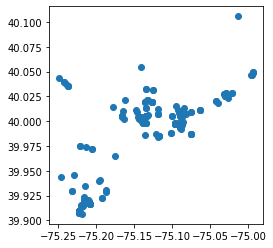

In [ ]:
#plotting it just to look, not a great plot!
licensedjunk.plot()

In [ ]:
#just a little exploration of license status
licensedjunk["licensesta"].head()



85134    Inactive
85173    Inactive
85174    Inactive
85175    Inactive
85179    Inactive
Name: licensesta, dtype: object

## Getting Every License Attached to Known Junkyard Locations aka Junkyards_lic

In [ ]:
#discovering that object ID won't pull everything related to a location.
testrun = licenses[licenses["objectid"] == 363387]
testrun

,objectid,addressobj,address,zip,censustrac,parcel_id_,opa_accoun,opa_owner,licensenum,revenuecod,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
359723,363387,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,846057,3374,...,Active,None,None,HELPING HANDS RECYCLING INC,Company,HELPING HANDS RECYCLING INC,"2335 WHEATSHEAF LN PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)


In [ ]:
#addressobj is better than object ID
testrun2 = licenses[licenses["addressobj"] == 15410490.0]
testrun2

,objectid,addressobj,address,zip,censustrac,parcel_id_,opa_accoun,opa_owner,licensenum,revenuecod,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
78574,79302,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,281318,3230,...,Inactive,None,None,ATLANTIC SYSTEMS INC,Company,ATLANTIC SYSTEMS INC,"2201 E BUTLER ST PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
80438,81275,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,283318,3311,...,Inactive,None,None,ATLANTIC SYSTEMS INC,Company,ATLANTIC SYSTEMS INC,"2201 E BUTLER ST PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
83386,83661,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,285948,3335,...,Inactive,None,None,ATLANTIC SYSTEMS INC,Company,ATLANTIC SYSTEMS INC,"2201 E BUTLER ST PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
174950,175931,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,474389,3311,...,Inactive,None,None,DIVERSIFIED TOWING & RECOVERY INC,Company,DIVERSIFIED TOWING & RECOVERY INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
174951,175932,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,474391,3230,...,Inactive,None,None,DIVERSIFIED TOWING & RECOVERY INC,Company,DIVERSIFIED TOWING & RECOVERY INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
174952,175933,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,474392,3335,...,Inactive,None,None,DIVERSIFIED TOWING & RECOVERY INC,Company,DIVERSIFIED TOWING & RECOVERY INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
191252,190906,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,507947,3822,...,Inactive,None,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
191253,190907,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,507948,3822,...,Inactive,None,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
279542,267860,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,658318,3335,...,Inactive,None,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)
296246,301727,15410490.0,2335 WHEATSHEAF LN,19137-1025,382,295956,884195003,NGUYEN APRIL,723987,3374,...,Inactive,None,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,POINT (-75.09015 39.99912)


In [ ]:
#gathering licenses by matching by business name
licensedjunk_bizname = licenses[licenses.business_n.isin(licensedjunk["business_n"])]
licensedjunk_bizname.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 826 entries, 73436 to 394130
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    826 non-null    int64   
 1   addressobj  739 non-null    float64 
 2   address     751 non-null    object  
 3   zip         751 non-null    object  
 4   censustrac  751 non-null    object  
 5   parcel_id_  709 non-null    object  
 6   opa_accoun  689 non-null    object  
 7   opa_owner   689 non-null    object  
 8   licensenum  826 non-null    object  
 9   revenuecod  826 non-null    object  
 10  licensetyp  826 non-null    object  
 11  initialiss  826 non-null    object  
 12  mostrecent  826 non-null    object  
 13  expiration  798 non-null    object  
 14  inactiveda  489 non-null    object  
 15  licensesta  826 non-null    object  
 16  legalfirst  213 non-null    object  
 17  legallastn  213 non-null    object  
 18  legalname   826 non-null    object 

In [ ]:
# matching by address obj
licensedjunk_adreso = licenses[licenses.addressobj.isin(licensedjunk["addressobj"])]
licensedjunk_adreso.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 765 entries, 431 to 394130
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    765 non-null    int64   
 1   addressobj  765 non-null    float64 
 2   address     765 non-null    object  
 3   zip         765 non-null    object  
 4   censustrac  765 non-null    object  
 5   parcel_id_  718 non-null    object  
 6   opa_accoun  691 non-null    object  
 7   opa_owner   691 non-null    object  
 8   licensenum  765 non-null    object  
 9   revenuecod  765 non-null    object  
 10  licensetyp  765 non-null    object  
 11  initialiss  765 non-null    object  
 12  mostrecent  765 non-null    object  
 13  expiration  728 non-null    object  
 14  inactiveda  424 non-null    object  
 15  licensesta  765 non-null    object  
 16  legalfirst  214 non-null    object  
 17  legallastn  214 non-null    object  
 18  legalname   765 non-null    object  


I get more unique address objects when I match by business name and more unique business names when I match by address object, which means that either method misses some of the other. However, it's not clear whether all those uniques are important because this dataset has a lot of redundancies, inconsistent data entries for the same info, and simply messy info.

First, I compare how many unique address obj I get by matching licenses to the business name of the junkyard vs by matching licenses to the address obj of the junkyard.

In [ ]:
# I get more unique address obj when I match by business names.
licensedjunk_bizname["addressobj"].nunique()

199

In [ ]:
#same number of of unique addressobj as in licensedjunk. Except licensedjunk 
#had 269 licenses. Is that a good sign?
licensedjunk_adreso["addressobj"].nunique()

144

In [ ]:
#unique business names matching by business name
licensedjunk_bizname["business_n"].nunique()

244

In [ ]:
#unique business names matching by address obj. Way more!
licensedjunk_adreso["business_n"].nunique()

384

In [ ]:
licensedjunk_bizname["geometry"].nunique()

172

In [ ]:
licensedjunk_adreso["geometry"].nunique()

126

Above, you can see that parcel values are a mess!!! Non uniform string length, negative numbers, missing values... Parcel -884790010 is actually that business's OPA account id. I used the data visualization tool to explore how parcels and addresses are used throughout the dataset and found many parcel IDs switched with OPA accounts, but not consistently enough to use that to fix it, especially as the OPA account data has its own problems (see below).

Gah, neither of these is an obvious choice to capture all the information. Though number of unique in either category doesn't necessarily guarantee a more complete dataset. The uniqueness can just be typos, different spellings, redundancies, mixups of information, etc that add disorder without adding relevant information. Geometry is more computationally intense but seems like the safest match given the holes and inconsistencies in address object and business name. The risk is if points are misentered in such a way that they won't match for the same location, but the results should tell me if that's a huge problem.

In [ ]:
# matching licenses by geometry
junkyards_lic = licenses[licenses.geometry.isin(licensedjunk["geometry"])]

In [ ]:
junkyards_lic.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 866 entries, 431 to 394130
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    866 non-null    int64   
 1   addressobj  844 non-null    float64 
 2   address     866 non-null    object  
 3   zip         866 non-null    object  
 4   censustrac  866 non-null    object  
 5   parcel_id_  819 non-null    object  
 6   opa_accoun  791 non-null    object  
 7   opa_owner   791 non-null    object  
 8   licensenum  866 non-null    object  
 9   revenuecod  866 non-null    object  
 10  licensetyp  866 non-null    object  
 11  initialiss  866 non-null    object  
 12  mostrecent  866 non-null    object  
 13  expiration  821 non-null    object  
 14  inactiveda  476 non-null    object  
 15  licensesta  866 non-null    object  
 16  legalfirst  233 non-null    object  
 17  legallastn  233 non-null    object  
 18  legalname   866 non-null    object  


Wooo, there are more unique business names in this matching strategy than the others, so I probably didn't lose useful data.

In [ ]:
junkyards_lic["geometry"].nunique()

126

In [ ]:
junkyards_lic["business_n"].nunique()

422

I imported the Philadelphia parcel data/map to compare it to this. On https://atlas.phila.gov/3100%20S%2061ST%20ST I figured out that one location with an OPA account as its parcel number has the official parcel number 047S220022. In the parcel dataset, that is in the MAPREG column. More below...

# Connecting Licenses and Parcels

## Philly Parcels GeoDataframe

Now that I have all the locations with known junkyard licenses and all their relevant permits (I hope!), I'm going to add those parcel columns from the parcel dataset. I think it'll make it easier if I do this before I add in all the violations.

MAPREG is the column in the parcel dataset that matches the parcel section of Atlas Philly (the public website of Philly real estate data and deeds) https://atlas.phila.gov/. The PARCEL column in business licenses is very strange (apparently negatives aren't an aberration) and doesn't match this dataset at all, column-wise. I can't use PARCEL columns or street addresses (also a mess) to join the business licenses to any other dataset. However, the business license data is points and the parcel data is shapes/polygons, so I should be able to connect them by business license locations that fall within parcel polygons.

The Philly Parcels dataset is huge! After importing it once, I imported only a conservative estimate of the columns I think I might need.

In [ ]:
#importing Philly Parcel data, with only useful columns
phillyparcels = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/datasets/1c57dd1b3ff84449a4b0e3fb29d3cafd_0.zip")[["ADDR_SOURC", "MAPREG", 
                                       "RECMAP", "PARCEL",
                                        "PWD_REVIEW", "DOR_REVIEW", "geometry"]]

In [ ]:
phillyparcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 606508 entries, 0 to 606507
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ADDR_SOURC  600296 non-null  object  
 1   MAPREG      606353 non-null  object  
 2   RECMAP      606342 non-null  object  
 3   PARCEL      606142 non-null  object  
 4   PWD_REVIEW  25008 non-null   object  
 5   DOR_REVIEW  25351 non-null   object  
 6   geometry    606482 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 32.4+ MB


###  Plotting Junkyard Licenses Over Parcels

The test plot below warns me of a problem to deal with: there are so many more parcels in Philadelphia than scrapyards that they overwhelm the map and take forever to load. I can't just get rid of most of them, though, because I might need them and they provide informational context (such as the ability to calculate city area with things like streets and rivers removed). I'll probably just extract the relevant parcels into a separate layer later.

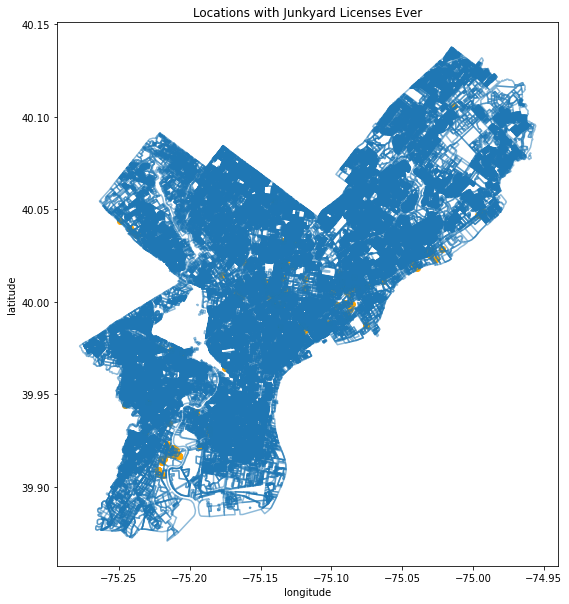

In [ ]:
#plotting licensed junkyard sites over parcels
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
phillyparcels.boundary.plot(ax=ax, alpha=0.5)
plt.title("Locations with Junkyard Licenses Ever")
licensedjunk.plot(ax=ax, c="Orange", alpha=1);

In [ ]:
#looking at that parcel that had a negative parcel code in the license data.
weird = phillyparcels[phillyparcels["MAPREG"]=="047S220022"]
print(weird)

            ADDR_SOURC      MAPREG  RECMAP PARCEL PWD_REVIEW DOR_REVIEW  \
413266  3103 S 61ST ST  047S220022  047S22   0022       None       None   

                                                 geometry  
413266  POLYGON ((-75.21140 39.91971, -75.21147 39.919...  


## Projecting Layers

In [ ]:
print("The CRS of Philadelphia parcels is:", phillyparcels.crs)


The CRS of Philadelphia parcels is: epsg:4326


In [ ]:
print("The CRS of all licenses associated with junkyards is", junkyards_lic.crs)

The CRS of all licenses associated with junkyards is epsg:4326


In [ ]:
print("The CRS of the junkyard licenses is:", junkyards_lic.crs)

The CRS of the junkyard licenses is: epsg:4326


In [ ]:
#importing the basic boundary of Philadelphia
phillyborders = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.zip")

In [ ]:
print("The CRS of the border shape of Philly is:", phillyborders.crs)

The CRS of the border shape of Philly is: epsg:4326


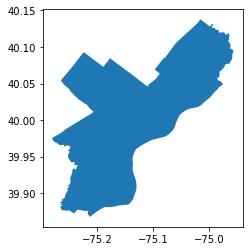

In [ ]:
phillyborders.plot()

In [ ]:
#converting the all-licenses dataframe to 2272
junkyards_lic_proj = junkyards_lic.to_crs("EPSG:2272")

In [ ]:
# projecting the border of Philly to 2272
philly_proj = phillyborders.to_crs("EPSG:2272")

In [ ]:
print("The CRS for Philly parcel data is:", phillyparcels.crs)

The CRS for Philly parcel data is: epsg:4326


In [ ]:
# making projected version of Philly parcel data
phillyparc_proj = phillyparcels.to_crs("EPSG:2272")

# Joining Parcels to Full Licenses Dataframe

In [ ]:
#projecting the junkyard licenses to 2272
junkyards_lic_proj = junkyards_lic.to_crs(2272)

In [ ]:
# spatial joining projected parcels and junkyard data
junkyards_licparc = phillyparc_proj.sjoin(junkyards_lic_proj, how="inner")

## Checking the results of the spatial join

In [ ]:
#joined geodataframe
junkyards_licparc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   1086 non-null   object  
 1   MAPREG       1167 non-null   object  
 2   RECMAP       1167 non-null   object  
 3   PARCEL       1166 non-null   object  
 4   PWD_REVIEW   154 non-null    object  
 5   DOR_REVIEW   154 non-null    object  
 6   geometry     1167 non-null   geometry
 7   index_right  1167 non-null   int64   
 8   objectid     1167 non-null   int64   
 9   addressobj   1141 non-null   float64 
 10  address      1167 non-null   object  
 11  zip          1167 non-null   object  
 12  censustrac   1167 non-null   object  
 13  parcel_id_   1092 non-null   object  
 14  opa_accoun   1051 non-null   object  
 15  opa_owner    1051 non-null   object  
 16  licensenum   1167 non-null   object  
 17  revenuecod   1167 non-null   object  
 18  licensetyp   116

# Joining Simple Junkyard License Info to Parcels for Export

I used the resulting dataframe for the L&I violations notebook.

In [ ]:
print("The CRS of junkyard licenses is" , licensedjunk.crs)

The CRS of junkyard licenses is epsg:4326


In [ ]:
# converting to EPSG 2272
junkliclocations = licensedjunk.to_crs(2272)

In [ ]:
#joining projected junkyard licenses to parcels
junkyardparcproj = phillyparc_proj.sjoin(junkliclocations, how="inner")

In [ ]:
junkyardparcproj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 384 entries, 939 to 602589
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   356 non-null    object  
 1   MAPREG       384 non-null    object  
 2   RECMAP       384 non-null    object  
 3   PARCEL       383 non-null    object  
 4   PWD_REVIEW   65 non-null     object  
 5   DOR_REVIEW   65 non-null     object  
 6   geometry     384 non-null    geometry
 7   index_right  384 non-null    int64   
 8   objectid     384 non-null    int64   
 9   addressobj   384 non-null    float64 
 10  address      384 non-null    object  
 11  zip          384 non-null    object  
 12  censustrac   384 non-null    object  
 13  parcel_id_   337 non-null    object  
 14  opa_accoun   322 non-null    object  
 15  opa_owner    322 non-null    object  
 16  licensenum   384 non-null    object  
 17  revenuecod   384 non-null    object  
 18  licensetyp   384 

In [ ]:
junkyardparcproj.rename({"address": "address_licdata"}, axis=1, inplace=True)

In [ ]:
junkyardparcproj = junkyardparcproj.drop(columns=["revenuecod"], axis = 1)

In [ ]:
junkyardparcproj.rename({"ADDR_SOURC": "address", "MAPREG": "parcel_full", 
                      "RECMAP": "map_section", "PARCEL": "map_parcel",
                      "PWD_REVIEW": "PWD_review", "DOR_REVIEW": "DOR_review"},
                     axis=1, inplace=True)

I kept a lot of columns before exporting. While I probably shouldn't have done that, I'm going to leave it as is for now.

In [ ]:
junkyardparcproj = junkyardparcproj[['address', 'map_section', 'map_parcel', 
                               'parcel_full', 'PWD_review', 'DOR_review',
                               'address_licdata', 'zip', 'opa_accoun', 
                               'opa_owner', 'licensenum', 'licensetyp', 
                               'initialiss', 'mostrecent', 
                               'expiration', 'inactiveda', 'licensesta', 
                               'legalfirst', 'legallastn', 'legalname', 
                               'legalentit', 'business_n', 'business_m', 
                               'geocode_x', 'geocode_y', 'geometry']]

In [ ]:
#resetting index to continuous
junkyardparcproj.reset_index(inplace = True, drop=True)

In [ ]:
junkyardparcproj.head()

,address,map_section,map_parcel,parcel_full,PWD_review,DOR_review,address_licdata,zip,opa_accoun,opa_owner,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
0,None,047S11,0010,047S110010,None,None,6850 ESSINGTON AVE,19153-3413,884169500,PBF LOGISTICS PRODUCTS TE,...,Inactive,None,None,CHRIS AUTO PARTS II,Company,CHRIS AUTO PARTS II,"6750 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.678437e+06,218972.547295,"POLYGON ((2679160.849 219790.732, 2679137.703 ..."
1,None,047S17,0035,047S170035,None,None,6850 ESSINGTON AVE,19153-3413,884169500,PBF LOGISTICS PRODUCTS TE,...,Inactive,None,None,CHRIS AUTO PARTS II,Company,CHRIS AUTO PARTS II,"6750 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.678437e+06,218972.547295,"POLYGON ((2678435.960 218926.501, 2678379.218 ..."
2,None,047S17,0026,047S170026,None,None,6850 ESSINGTON AVE,19153-3413,884169500,PBF LOGISTICS PRODUCTS TE,...,Inactive,None,None,CHRIS AUTO PARTS II,Company,CHRIS AUTO PARTS II,"6750 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.678437e+06,218972.547295,"POLYGON ((2679159.954 219790.563, 2679136.835 ..."
3,6101 W PASSYUNK AVE,047S21,0023,047S210023,None,None,6101 W PASSYUNK AVE,19143-0000,882895500,JOES KWIK MARTS LLC,...,Inactive,None,None,GIANNA SALVAGE CORP,Company,GIANNA SALVAGE CORP,"6800 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.680928e+06,223375.011346,"POLYGON ((2680829.298 223301.310, 2680808.700 ..."
4,6101 W PASSYUNK AVE,047S21,0044,047S210044,Completed,Completed,6101 W PASSYUNK AVE,19143-0000,882895500,JOES KWIK MARTS LLC,...,Inactive,None,None,GIANNA SALVAGE CORP,Company,GIANNA SALVAGE CORP,"6800 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.680928e+06,223375.011346,"POLYGON ((2680825.903 223299.337, 2680819.922 ..."


In [ ]:
# code I used to export that
#junkyardparcproj.to_file("/content/content/MyDrive/Colab Notebooks/PhillyJunkyardLocations.geojson", driver="GeoJSON")

In [ ]:
ls

sample_data/


# Cleaning Preprocessing Full Licenses Dataframe for Model
There are some very similar columns here and columns whose contents make no sense unless you read the metadata for their source. I'm renaming them to be a little clearer.

In [ ]:
#first renaming the business license address column, which is secondary to ADDR_SOURCE
junkyards_licparc.rename({"address": "address_licdata"}, axis=1, inplace=True)

In [ ]:
junkyards_licparc.columns

Index(['ADDR_SOURC', 'MAPREG', 'RECMAP', 'PARCEL', 'PWD_REVIEW', 'DOR_REVIEW',
       'geometry', 'index_right', 'objectid', 'addressobj', 'address_licdata',
       'zip', 'censustrac', 'parcel_id_', 'opa_accoun', 'opa_owner',
       'licensenum', 'revenuecod', 'licensetyp', 'initialiss', 'mostrecent',
       'expiration', 'inactiveda', 'licensesta', 'legalfirst', 'legallastn',
       'legalname', 'legalentit', 'business_n', 'business_m', 'geocode_x',
       'geocode_y'],
      dtype='object')

In [ ]:
#renaming the parcel data columns to be clearer and match formatting
junkyards_licparc.rename({"ADDR_SOURC": "address", "MAPREG": "parcel_full", 
                      "RECMAP": "map_section", "PARCEL": "map_parcel",
                      "PWD_REVIEW": "PWD_review", "DOR_REVIEW": "DOR_review"},
                     axis=1, inplace=True)

In [ ]:
junkyards_licparc.columns

Index(['address', 'parcel_full', 'map_section', 'map_parcel', 'PWD_review',
       'DOR_review', 'geometry', 'index_right', 'objectid', 'addressobj',
       'address_licdata', 'zip', 'censustrac', 'parcel_id_', 'opa_accoun',
       'opa_owner', 'licensenum', 'revenuecod', 'licensetyp', 'initialiss',
       'mostrecent', 'expiration', 'inactiveda', 'licensesta', 'legalfirst',
       'legallastn', 'legalname', 'legalentit', 'business_n', 'business_m',
       'geocode_x', 'geocode_y'],
      dtype='object')

I'm going to reorganize the columns and delete the ones we don't need for the model

In [ ]:
# moving geometry to end, deleting columns
junkyards_licenses = junkyards_licparc[['address', 'map_section', 'parcel_full', 
                                        'PWD_review', 'DOR_review', 'zip',
                                        'licensenum', 'licensetyp', 'geometry']]

In [ ]:
junkyards_licenses.tail()

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensenum,licensetyp,geometry
602589,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,686279,Handbill Distribution,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,826075,"Food Establishment, Retail Permanent Location","POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,826080,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,285891,Hazardous Materials,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,826079,Auto Wrecking / Junk Yard,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."


In [ ]:
# "address" (0) is now the name of the correct and standard-formatting addresses
junkyards_licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   address      1086 non-null   object  
 1   map_section  1167 non-null   object  
 2   parcel_full  1167 non-null   object  
 3   PWD_review   154 non-null    object  
 4   DOR_review   154 non-null    object  
 5   zip          1167 non-null   object  
 6   licensenum   1167 non-null   object  
 7   licensetyp   1167 non-null   object  
 8   geometry     1167 non-null   geometry
dtypes: geometry(1), object(8)
memory usage: 91.2+ KB


In [ ]:
#resetting index values so they're continuous
junkyards_licenses.reset_index(drop=True, inplace = True)

In [ ]:
junkyards_licenses.tail()

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensenum,licensetyp,geometry
1162,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,686279,Handbill Distribution,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1163,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,826075,"Food Establishment, Retail Permanent Location","POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1164,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,826080,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1165,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,285891,Hazardous Materials,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1166,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,826079,Auto Wrecking / Junk Yard,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."


In [ ]:
junkyards_licenses.nunique()

address        129
map_section     84
parcel_full    168
PWD_review       2
DOR_review       2
zip             96
licensenum     861
licensetyp      20
geometry       167
dtype: int64

In [ ]:
print("The shape of the full licenses dataset is", junkyards_licenses.shape, "rows, columns")

The shape of the full licenses dataset is (1167, 9) rows, columns


In [ ]:
junkyards_licenses[junkyards_licenses["licensenum"].isna()]

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensenum,licensetyp,geometry


So there are duplicate license numbers... Since it isn't that many, I assume it might be from a licensed that lapsed and was renewed being entered as two rows instead of one row with longer start and end dates. Who knows! Not really important here, because license type would still capture if a location had duplicates of the same kind.

In [ ]:
junkyards_licenses.drop(columns="licensenum", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
junkyards_licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   address      1086 non-null   object  
 1   map_section  1167 non-null   object  
 2   parcel_full  1167 non-null   object  
 3   PWD_review   154 non-null    object  
 4   DOR_review   154 non-null    object  
 5   zip          1167 non-null   object  
 6   licensetyp   1167 non-null   object  
 7   geometry     1167 non-null   geometry
dtypes: geometry(1), object(7)
memory usage: 73.1+ KB


### Making a Column of # of Diff License Types at Location

In [ ]:
junkyards_licenses["licensetype_count"] = junkyards_licenses.groupby("parcel_full")["licensetyp"].transform('nunique')

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
junkyards_licenses.tail()

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensetyp,geometry,licensetype_count
1162,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Handbill Distribution,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1163,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,"Food Establishment, Retail Permanent Location","POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1164,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1165,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Hazardous Materials,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1166,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Auto Wrecking / Junk Yard,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5


In [ ]:
junkyards_byparcel = junkyards_licenses.groupby("parcel_full")

Turns out parcel 047S110010 is a good test to make sure I'm doing this right, since it has 5 different licenses and one of those is duplicated (dumpster)

In [ ]:
junkyards_byparcel.get_group("047S110010")

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensetyp,geometry,licensetype_count
0,None,047S11,047S110010,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
3,None,047S11,047S110010,None,None,19153-3413,Hazardous Materials,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
6,None,047S11,047S110010,None,None,19153-3413,Dumpster License - Private Property,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
9,None,047S11,047S110010,None,None,19153-3413,Dumpster License - Private Property,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
12,None,047S11,047S110010,None,None,19153-3413,Scales and Scanners,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
15,None,047S11,047S110010,None,None,19153-3413,Auto Wrecking / Junk Yard,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5


In [ ]:
junkyards_byparcel.head()

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensetyp,geometry,licensetype_count
0,None,047S11,047S110010,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
1,None,047S17,047S170035,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5
2,None,047S17,047S170026,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2679159.954 219790.563, 2679136.835 ...",5
3,None,047S11,047S110010,None,None,19153-3413,Hazardous Materials,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
4,None,047S17,047S170035,None,None,19153-3413,Hazardous Materials,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5
...,...,...,...,...,...,...,...,...,...
1162,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Handbill Distribution,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1163,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,"Food Establishment, Retail Permanent Location","POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1164,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1165,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Hazardous Materials,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5


In [ ]:
junkyards_byparcel.describe()

licensetype_count                                   
                        count mean  std  min  25%  50%  75%  max
parcel_full                                                     
004N240112                5.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0
009S060029                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
009S060032                8.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0
009S060037                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
009S060043                8.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0
...                       ...  ...  ...  ...  ...  ...  ...  ...
150N240018                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
150N240031                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
150N240050                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
150N240056                6.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
155N090023               12.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0

[168 rows x 8 columns]

In [ ]:
junkyards_address = junkyards_licenses.groupby(["address"])

In [ ]:
junkyards_address.head()

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensetyp,geometry,licensetype_count
0,None,047S11,047S110010,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
1,None,047S17,047S170035,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5
2,None,047S17,047S170026,None,None,19153-3413,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2679159.954 219790.563, 2679136.835 ...",5
3,None,047S11,047S110010,None,None,19153-3413,Hazardous Materials,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5
4,None,047S17,047S170035,None,None,19153-3413,Hazardous Materials,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5
...,...,...,...,...,...,...,...,...,...
1162,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Handbill Distribution,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1163,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,"Food Establishment, Retail Permanent Location","POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1164,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1165,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Hazardous Materials,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5


In [ ]:
junkyards_address.get_group("2201-09 SPRING GARDEN ST")

,address,map_section,parcel_full,PWD_review,DOR_review,zip,licensetyp,geometry,licensetype_count
1162,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Handbill Distribution,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1163,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,"Food Establishment, Retail Permanent Location","POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1164,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Motor Vehicle Repair / Retail Mobile Dispensing,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1165,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Hazardous Materials,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5
1166,2201-09 SPRING GARDEN ST,004N24,004N240112,Completed,Completed,19130-3511,Auto Wrecking / Junk Yard,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",5


### Deleting Duplicate License Types Per Location

In [ ]:
junkyards_licenses = junkyards_licenses.drop_duplicates(["parcel_full", "licensetyp"])

In [ ]:
junkyards_licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 578 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   address            518 non-null    object  
 1   map_section        578 non-null    object  
 2   parcel_full        578 non-null    object  
 3   PWD_review         69 non-null     object  
 4   DOR_review         69 non-null     object  
 5   zip                578 non-null    object  
 6   licensetyp         578 non-null    object  
 7   geometry           578 non-null    geometry
 8   licensetype_count  578 non-null    int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 45.2+ KB


In [ ]:
junkyards_licenses["PWD_review"].unique()

array([None, 'Completed', 'Needed'], dtype=object)

In [ ]:
junkyards_licenses.columns

Index(['address', 'map_section', 'parcel_full', 'PWD_review', 'DOR_review',
       'zip', 'licensetyp', 'geometry', 'licensetype_count'],
      dtype='object')

## One Hot Encoding the License Types and Deleting Duplicates

In [147]:
lic_1he = pd.get_dummies(junkyards_licenses[["map_section", "licensetyp", 
                                             "PWD_review", "DOR_review", "zip"]]).reset_index().drop("index", axis=1)
lic_1he

,map_section_004N24,map_section_009S06,map_section_013S18,map_section_015S16,map_section_021N04,map_section_024N24,map_section_025S13,map_section_026S04,map_section_029S07,map_section_030N13,...,zip_19153-3503,zip_19153-3506,zip_19153-3507,zip_19153-3508,zip_19153-3513,zip_19153-3516,zip_19153-3522,zip_19153-3524,zip_19153-3529,zip_19153-3588
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
574,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
575,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
licenses_ohe = junkyards_licenses[['parcel_full', 'geometry', 
                                   'licensetype_count']].reset_index().drop("index", 
                                                                                   axis=1).join(lic_1he)
licenses_ohe.shape

(578, 207)

In [153]:
licenses_ohe.head()

,parcel_full,geometry,licensetype_count,map_section_004N24,map_section_009S06,map_section_013S18,map_section_015S16,map_section_021N04,map_section_024N24,map_section_025S13,...,zip_19153-3503,zip_19153-3506,zip_19153-3507,zip_19153-3508,zip_19153-3513,zip_19153-3516,zip_19153-3522,zip_19153-3524,zip_19153-3529,zip_19153-3588
0,047S110010,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,047S170035,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,047S170026,"POLYGON ((2679159.954 219790.563, 2679136.835 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,047S110010,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,047S170035,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
licenses_ohe3 = licenses_ohe.groupby("parcel_full").agg("max")

/usr/local/lib/python3.8/dist-packages/pandas/core/apply.py:577: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  return f(*args, **kwargs)


In [160]:
licenses_ohe3

,licensetype_count,map_section_004N24,map_section_009S06,map_section_013S18,map_section_015S16,map_section_021N04,map_section_024N24,map_section_025S13,map_section_026S04,map_section_029S07,...,zip_19153-3503,zip_19153-3506,zip_19153-3507,zip_19153-3508,zip_19153-3513,zip_19153-3516,zip_19153-3522,zip_19153-3524,zip_19153-3529,zip_19153-3588
parcel_full,,,,,,,,,,,,,,,,,,,,,
004N240112,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
009S060029,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
009S060032,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
009S060037,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
009S060043,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150N240018,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150N240031,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150N240050,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
licenses_ohe3.reset_index()

,parcel_full,licensetype_count,map_section_004N24,map_section_009S06,map_section_013S18,map_section_015S16,map_section_021N04,map_section_024N24,map_section_025S13,map_section_026S04,...,zip_19153-3503,zip_19153-3506,zip_19153-3507,zip_19153-3508,zip_19153-3513,zip_19153-3516,zip_19153-3522,zip_19153-3524,zip_19153-3529,zip_19153-3588
0,004N240112,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,009S060029,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,009S060032,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,009S060037,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,009S060043,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,150N240018,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,150N240031,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165,150N240050,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166,150N240056,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Rejoining with Geometry

In [177]:
geometry = licenses_ohe[["parcel_full", "geometry"]]

In [178]:
geometry.describe()

,parcel_full,geometry
count,578,578
unique,168,167
top,047S210049,POLYGON ((2680783.132597672 223162.62218585834...
freq,9,9


In [179]:
geometry = geometry.drop_duplicates(subset=["parcel_full"], keep='first')
geometry

,parcel_full,geometry
0,047S110010,"POLYGON ((2679160.849 219790.732, 2679137.703 ..."
1,047S170035,"POLYGON ((2678435.960 218926.501, 2678379.218 ..."
2,047S170026,"POLYGON ((2679159.954 219790.563, 2679136.835 ..."
15,047S210023,"POLYGON ((2680829.298 223301.310, 2680808.700 ..."
16,047S210044,"POLYGON ((2680825.903 223299.337, 2680819.922 ..."
...,...,...
552,009S060032,"POLYGON ((2684634.992 231397.724, 2684640.581 ..."
561,111N220010,"POLYGON ((2727858.623 261131.420, 2727876.458 ..."
566,047S200080,"POLYGON ((2680390.397 223711.413, 2680288.056 ..."
568,047S200071,"POLYGON ((2679266.293 223243.072, 2679413.183 ..."


In [180]:
geometry.reset_index(drop=True)

,parcel_full,geometry
0,047S110010,"POLYGON ((2679160.849 219790.732, 2679137.703 ..."
1,047S170035,"POLYGON ((2678435.960 218926.501, 2678379.218 ..."
2,047S170026,"POLYGON ((2679159.954 219790.563, 2679136.835 ..."
3,047S210023,"POLYGON ((2680829.298 223301.310, 2680808.700 ..."
4,047S210044,"POLYGON ((2680825.903 223299.337, 2680819.922 ..."
...,...,...
163,009S060032,"POLYGON ((2684634.992 231397.724, 2684640.581 ..."
164,111N220010,"POLYGON ((2727858.623 261131.420, 2727876.458 ..."
165,047S200080,"POLYGON ((2680390.397 223711.413, 2680288.056 ..."
166,047S200071,"POLYGON ((2679266.293 223243.072, 2679413.183 ..."


In [181]:
licenses_ohe_full = pd.merge(geometry, licenses_ohe3, on="parcel_full")

In [182]:
licenses_ohe_full

,parcel_full,geometry,licensetype_count,map_section_004N24,map_section_009S06,map_section_013S18,map_section_015S16,map_section_021N04,map_section_024N24,map_section_025S13,...,zip_19153-3503,zip_19153-3506,zip_19153-3507,zip_19153-3508,zip_19153-3513,zip_19153-3516,zip_19153-3522,zip_19153-3524,zip_19153-3529,zip_19153-3588
0,047S110010,"POLYGON ((2679160.849 219790.732, 2679137.703 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,047S170035,"POLYGON ((2678435.960 218926.501, 2678379.218 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,047S170026,"POLYGON ((2679159.954 219790.563, 2679136.835 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,047S210023,"POLYGON ((2680829.298 223301.310, 2680808.700 ...",6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,047S210044,"POLYGON ((2680825.903 223299.337, 2680819.922 ...",6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,009S060032,"POLYGON ((2684634.992 231397.724, 2684640.581 ...",5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,111N220010,"POLYGON ((2727858.623 261131.420, 2727876.458 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165,047S200080,"POLYGON ((2680390.397 223711.413, 2680288.056 ...",2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166,047S200071,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
licenses_ohe_full.columns.tolist()

['parcel_full',
 'geometry',
 'licensetype_count',
 'map_section_004N24',
 'map_section_009S06',
 'map_section_013S18',
 'map_section_015S16',
 'map_section_021N04',
 'map_section_024N24',
 'map_section_025S13',
 'map_section_026S04',
 'map_section_029S07',
 'map_section_030N13',
 'map_section_030S16',
 'map_section_032S17',
 'map_section_033S13',
 'map_section_038N23',
 'map_section_038N24',
 'map_section_039N09',
 'map_section_040N17',
 'map_section_041N16',
 'map_section_042N23',
 'map_section_042N24',
 'map_section_043N02',
 'map_section_043N15',
 'map_section_044N07',
 'map_section_044N08',
 'map_section_044S13',
 'map_section_044S19',
 'map_section_045N17',
 'map_section_046N05',
 'map_section_047N12',
 'map_section_047S11',
 'map_section_047S17',
 'map_section_047S18',
 'map_section_047S20',
 'map_section_047S21',
 'map_section_047S22',
 'map_section_047S23',
 'map_section_050S21',
 'map_section_058N13',
 'map_section_059N09',
 'map_section_066N10',
 'map_section_074N04',
 'map_

## Plotting Junkyard Parcels (not sure where this goes)

### Conclusions about how to connect all the other data: use parcels, not address!
Parcel_full is probably the most authoritative and useful column. 

As you can see from the head of the dataframe, some parcels have no address even in the official parcel + address records. From looking at this data in another notebook, some parcels have multiple addresses attached. For example, "120-130 Bigparcel St" could be an address for one parcel, and then bad records or businesses sharing a site might use 123 Bigparcel St and 125 Bigparcel St for the same piece of land or even the same business. However, some addresses also have multiple parcels! See 3111 Grays Ferry Ave when I group by parcel below: it shows up as the address for multiple parcels. That address is a junkyard under I-76 and next to a freight line, so it's no surprise that it's a very weird lot.

Since some parcels have no address and the parcels have more systematic naming, the simplest way to deal with this for the full set of data is just using parcels.

Also, using parcels as a join key instead of geometry is a little more reliable (no CRS conversions or tiny numbers) and faster.

In [ ]:
#grouping by parcel
junkyparcels = phillyjunklic.groupby("parcel_full").first()

NameError: ignored

In [ ]:
f, ax = plt.subplots(figsize=(20,20))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
plt.title("Junkyard tracts over Philly")
junkyparcels.plot(ax=ax, color="Orange")
philly_proj.boundary.plot(ax=ax, alpha=0.5)

Unsurprisingly, the junkyards are concentrated in Southwest Philly, the Riverwards near the Delaware River, and North Philly.

# Ignore this Irrelevant Thing! Exporting Junkyard Business License Data and Locations (as Parcels)

I'm going to save this to Google Drive and our Github folder.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive.mount("content")

In [ ]:
cd /content/content/MyDrive/Colab Notebooks

In [ ]:
ls

In [ ]:
#exporting dataframe to my Google Drive Colab folder as a GeoJSON
#your filepath may be different! Name the file however you want at the end
phillyjunklic.to_file("/content/content/MyDrive/Colab Notebooks/PhillyJunkLicensesLocations.geojson", driver="GeoJSON")

## Let's see if that works...

In [ ]:
cd /content/content/MyDrive/Colab Notebooks

In [ ]:
ls

## Importing the GeoJSON into geopandas to test

Originally, I exported/imported this as a csv, but then I heard Dr. Bianco say that can alter some of the more precise numbers and to use GeoJSON.

Here's the CSV code:


```
# first read in data as csv
testjunk = pd.read_csv("PhillyJunkLicensesLocations.csv")

# then build geodataframe from imported csv dataframe
testjunk = gpd.GeoDataFrame(testjunk, geometry=gpd.GeoSeries.from_wkt(testjunk["geometry"]), crs="epsg:2272")
```



In [ ]:
testjunk = gpd.read_file("PhillyJunkLicensesLocations.geojson")

In [ ]:
# testing that data matches
testjunk.info()

In [ ]:
testjunk.head()

In [ ]:
print("The CRS of this test dataset is", testjunk.crs)

In [ ]:
junkyparcels

# Not Important: Creating Dataframe of active junkyard licenses for later and comparison

In [ ]:
#extracting active junkyard licenses
activejunk = licensedjunk[licensedjunk["licensesta"] == "Active"]

In [ ]:
activejunk

There are 52 entries with active junkyard licenses. This probably corresponds better to unique sites than the all licenses data, but we'll find out!

In [ ]:
licensedjunk.info()

In [ ]:
licensedjunk.nunique()

Only 125 unique geometry points out of 269 rows! You can also see that almost every other unique identifier is missing rows. Addressobj has the most nuniques, though, so I'm going to hope that's the most comprehensive.

In [ ]:
activejunk.nunique()

In some code I deleted, I was trying to get a sense of how much business name, address, and parcel are the same. For example, will the same business name mostly have the same address and parcel, or will it have such varied addresses that we'd need to look for bad data or changes of business location? Will the same parcel have a consistent address? Will the same address have a consistent parcel? This isn't necessarily important to our research at the moment, but it's something to dig into more if we go further.